# Temperature Prediction for 5 Cities in the USA
## Rajat Gupta

An analysis is being performed here to analyze the variation in temperatures for different cities in the United States to determine any trend across the years and make predictions for the future based on current data using time series analysis on Python.

The data is obtained from [Berkley Earth](http://berkeleyearth.org/data/) and contains the average monthly temperature for various cities around the world.

All Temperature values are in Celsius.

In [1]:
#import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
%matplotlib inline

C:\Users\sunil\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#Load the data, and set the 'dt' column as a datetime object
data = pd.read_csv('GlobalLandTemperaturesByCity.csv', parse_dates=['dt'])

The analysis is being performed for 5 cities across different regions of the United States namely:
1. Chicago
2. New York
3. Minneapolis
4. Houston
5. Los Angeles

These cities are chosen because they represent different climates, geography in the same country.

We are also dividing the data to test the time series analysis on existing data values. In this case, this testing data is chosen as the temperature values beginning January 2012 and after. The training dataset contains the temperature data from January 1800 (for the cities available) to December 2011.

In [3]:
#Creating the testing dataset having values after 2012 for the selecred cities to test the predictions made later
test_data = {}

#all data for the respective cities is stored in city_selected
city_selected = ["Chicago", "New York", "Minneapolis", "Houston", "Los Angeles"]
for city in city_selected:
    test_data[city] = data[(data['Country']=='United States')&(data['dt']>pd.datetime(2011,12,1))&(data['City']==city)]
    test_data[city] = test_data[city].reset_index(drop = True)

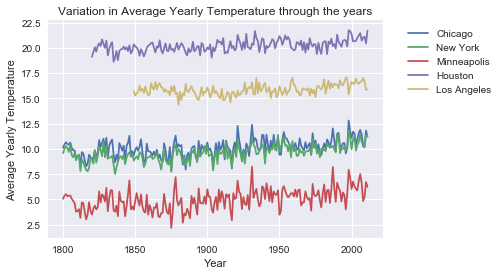

In [4]:
def City_data (city, country, data):
    '''Function to return the data for selected cities'''
    country_data = data[(data['Country']==country)&(data['dt']>=pd.datetime(1800,1,1))&(data['dt']<pd.datetime(2012,1,1))]
    city_data = country_data[country_data['City']==city]
    city_data = city_data.reset_index(drop = True)
    return city_data

def average_yearly_data (data):
    '''Function to return the average yearly temperature'''
    i = 0
    returned_data = {'Year':[], 'YearlyTemperature': []}
    year = data.iloc[i,0].year
    while(year<2011):
        year = data.iloc[i,0].year
        avg_year = 0
        n = 0
        while(n<12):
            avg_year += data.iloc[i,1]
            i += 1
            n += 1
        avg_year = avg_year/n
        returned_data['Year'].append(year)
        returned_data['YearlyTemperature'].append(avg_year)
        
    return pd.DataFrame(returned_data)

#the average yearly data for these cities is stored in average_yearly_city_data
city_data = {}
average_yearly_city_data = {}
for city in city_selected:
    city_data[city] = City_data(city, 'United States', data)
    average_yearly_city_data[city] = average_yearly_data(city_data[city])
    plt.plot(average_yearly_city_data[city]['Year'], average_yearly_city_data[city]['YearlyTemperature'], label = city)
    plt.legend(bbox_to_anchor=(1.05,1), loc=2)

plt.xlabel('Year')
plt.ylabel('Average Yearly Temperature')
plt.title('Variation in Average Yearly Temperature through the years')

From the above plot we see that the average temperature each year is varying a lot for each of the selected cities. Also, there seems to be a slight increase in the yearly temperatures post 1900. Just to be sure we will visualize this period specifically.

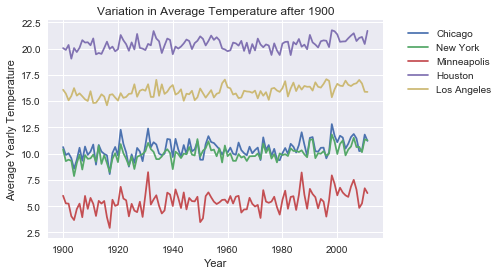

In [5]:
data_for_year_after_1900 = {}
for city in city_selected:
    condition = average_yearly_city_data[city]['Year']>=1900
    data_for_year_after_1900[city] = average_yearly_city_data[city][condition]
    plt.plot(data_for_year_after_1900[city]['Year'], data_for_year_after_1900[city]['YearlyTemperature'], label=city)
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.xlabel('Year')
plt.ylabel('Average Yearly Temperature')
plt.title('Variation in Average Temperature after 1900')

Even now looking at the plot no clear trend is observed, the temperature increases and decreases in no particular fashion. However, the increase and decrease in yearly temperature appears to be at the same time (a little different for Los Angeles) for the different cities.

To analyze the data further, we perform a decomposition of the temperature data for these cities in order to visualize the trend, seasonality and the residuals for the temperature data of the respective cities.

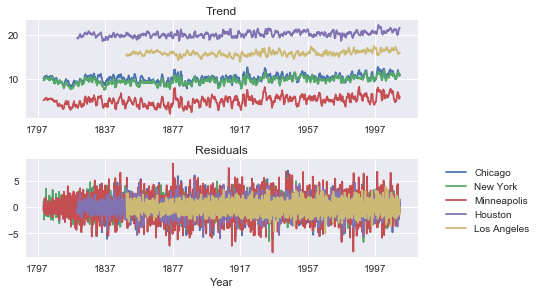

In [6]:
# storing the seasonality seperately to make the graph
seasonality = {}

fig1 = plt.subplot(2,1,1)
fig2 = plt.subplot(2,1,2)
for city in city_selected:
    city_data[city] = city_data[city].set_index('dt')
    decomposition = seasonal_decompose(city_data[city]['AverageTemperature'])
    trend = decomposition.trend
    seasonality[city] = decomposition.seasonal
    residuals = decomposition.resid
    fig1.plot(trend, label=city)
    fig1.set_title('Trend')
    fig2.plot(residuals, label=city)
    fig2.set_title('Residuals')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.xlabel('Year')

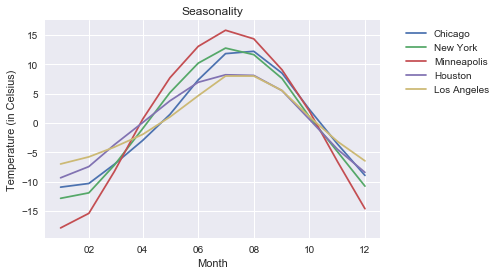

In [7]:
#plotting the seasonality values over a year for each of the cities

#Set the x axis to just show the monthly values
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m'))

for city in (seasonality.keys()):
    plt.plot(seasonality[city][-12:], label = city)
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.title('Seasonality')
plt.ylabel('Temperature (in Celsius)')
plt.xlabel('Month')

The following observations are noted from the plots above:
1. There is no discernable trend in the data for any of the cities.
2. The variation in residuals appear to be slightly increasing with time (more prominent for Minneapolis and Los Angeles) and vary a lot for each of the cities under study.
3. The seasonal variation through the year is very high peaking during the month of July and having minimum value in January. Also, the seasonal plot has a normal pattern for each of the cities under study.

To make predictions on the temperature for years to come, we will now check the data for stationarity by performing the augmented Dickey-Fuller Test.

In [8]:
def stationary_stat_city(test_data):
    print ('Test Statistic: ' + str(test_data[0]))
    print ('P value: ' + str(test_data[1]))
    print ('Number of Observations: '+ str(test_data[3]))
    print ('Critical Value 1%: '+ str(test_data[4]['1%']))
    print ('Critical Value 5%: '+ str(test_data[4]['5%']))
    print ('Critical Value 10%: '+ str(test_data[4]['10%']))
        
test_output = {}
for city in city_selected:
    test_output[city] = adfuller(city_data[city]['AverageTemperature'])
    print ('Statistics for ' + city)
    stationary_stat_city(test_output[city])
    print()

Statistics for Chicago
Test Statistic: -6.01784561087
P value: 1.51856936394e-07
Number of Observations: 2517
Critical Value 1%: -3.43295070782
Critical Value 5%: -2.86268898231
Critical Value 10%: -2.5673816472

Statistics for New York
Test Statistic: -4.39157518599
P value: 0.000307190680408
Number of Observations: 2517
Critical Value 1%: -3.43295070782
Critical Value 5%: -2.86268898231
Critical Value 10%: -2.5673816472

Statistics for Minneapolis
Test Statistic: -6.38233503581
P value: 2.20661117556e-08
Number of Observations: 2517
Critical Value 1%: -3.43295070782
Critical Value 5%: -2.86268898231
Critical Value 10%: -2.5673816472

Statistics for Houston
Test Statistic: -6.06219097837
P value: 1.20516892333e-07
Number of Observations: 2276
Critical Value 1%: -3.43322640183
Critical Value 5%: -2.86281072408
Critical Value 10%: -2.56744646493

Statistics for Los Angeles
Test Statistic: -5.68905824708
P value: 8.15080515149e-07
Number of Observations: 1929
Critical Value 1%: -3.433744

It is seen that the value of test statistic is greater (more negative) than the 1% critical values for each of the selected studies. Thus, we can reject the null hyothesis of a unit root being present in the data set and we can conclude with more than 99% confidence that this is a stationary series.

To make future predictions using the ARIMA model, we first need to determine the values of its coefficients which is done through plotting the Autocorrelation and the Partial autocorrelation functions.

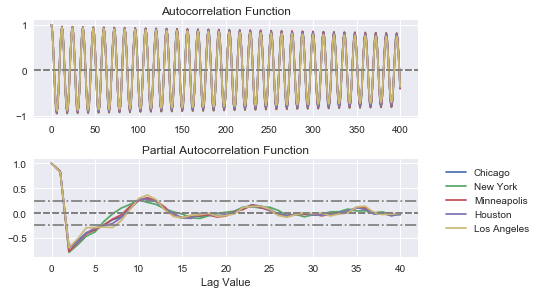

In [9]:
acf_val = {}
pacf_val = {}

fig1 = plt.subplot(2,1,1)
fig1.set_title('Autocorrelation Function')

fig2 = plt.subplot(2,1,2)
fig2.set_title('Partial Autocorrelation Function')

for city in city_selected:
    acf_val[city] = acf(city_data[city]['AverageTemperature'], nlags = 400)
    pacf_val[city] = pacf(city_data[city]['AverageTemperature'])
    fig1.plot(acf_val[city], label=city)
    fig1.axhline(y=0,linestyle='--',color='gray')
    fig2.plot(pacf_val[city], label=city)
    fig2.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=(-1.96*np.std(city_data[city]['AverageTemperature']))/np.sqrt(len(city_data[city])),linestyle='-.',color='gray')
plt.axhline(y=(1.96*np.std(city_data[city]['AverageTemperature']))/np.sqrt(len(city_data[city])),linestyle='-.',color='gray')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.xlabel('Lag Value')

We can see from plotting the autocorrelation function that the value of the function actually does decay but this decay is very slow. However, the decay for the Partial Autocorrelation function is much faster. Also, for the autocorrelation function the value peaks at 0 (shown below) and both the functions are similar for each of the cities under study.

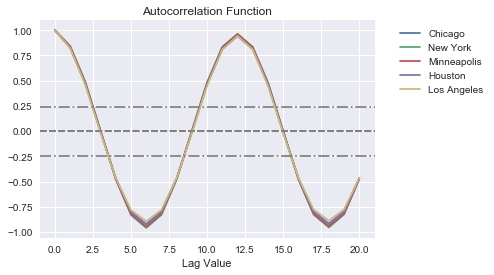

In [10]:
acf_val_small = {}
for city in city_selected:
    acf_val_small[city] = acf(city_data[city]['AverageTemperature'], nlags = 20)
    plt.plot(acf_val_small[city], label = city)
    plt.axhline(y=0,linestyle='--',color='gray')

#Plotting the 95% confidence intervals
plt.axhline(y=(-1.96*np.std(city_data[city]['AverageTemperature']))/np.sqrt(len(city_data[city])),linestyle='-.',color='gray')
plt.axhline(y=(1.96*np.std(city_data[city]['AverageTemperature']))/np.sqrt(len(city_data[city])),linestyle='-.',color='gray')

plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.title('Autocorrelation Function')
plt.xlabel('Lag Value')

From the above plots for Autocorrelation function and the Partial Autocorrelation function we conclude that the ARIMA model we will be using will have the following input parameters:

p = 6 (Lag Value where the PACF cuts of lower confidence level while rising for the first time)

q = 0 (Lag Value where the ACF is above the upper confidence level the first time)

d = 0 (Order of differencing used to perform the analysis)

In [11]:
#Defining different variables to store the different values which are being calculated.
#Forecasting for time steps in the future we have the data for (entire 2012 and 9 months of 2013) = 21
model_arima = {}
results_model = {}
forecast_model = {}
for city in city_selected:
    pred_name = ""
    model_arima[city] = ARIMA(city_data[city]['AverageTemperature'], order = (6,0,0)).fit()
    forecast_model[city] = model_arima[city].forecast(steps = 21)
    results_model[city] = model_arima[city].fittedvalues

We will now compare the predictions made by our model with the actual values obtained for the year of 2013 available from the data for each of the cities.

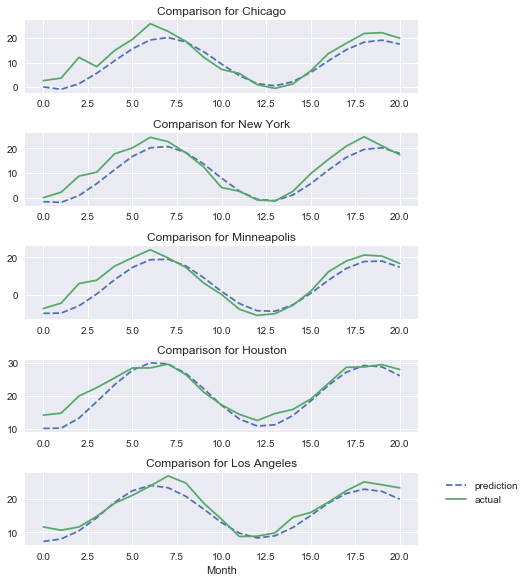

In [12]:
fig = []
i = 0
for city in city_selected:
    predictions = forecast_model[city][0]
    fig.append(plt.subplot(5,1,i+1))
    fig[i].plot(predictions, label = "prediction", linestyle='--')
    fig[i].plot(test_data[city]['AverageTemperature'], label = "actual")
    fig[i].set_title('Comparison for '+ city)
    i += 1
plt.gcf().set_size_inches(6,8)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.xlabel('Month')

We can see that our analysis predicts the variation in the temperature data very well but the exact values are off. To calculate this error which is occurring between the forecasted and the actual values, we will calculate the root mean squared error for the temperature values for each of the cities under study.

In [13]:
mean_sq_error = {}
print ('Root Mean Square Errors:')
for city in city_selected:
    mean_sq_error[city] = sqrt(mean_squared_error(test_data[city]['AverageTemperature'], forecast_model[city][0]))
    print (city + ": " + str(mean_sq_error[city]))

Root Mean Square Errors:
Chicago: 3.716350881981819
New York: 3.6606289411428845
Minneapolis: 4.476508998071626
Houston: 2.528676245738872
Los Angeles: 2.1337737260156424


From the graphs and the rms errors calculated for each of the cities, we see that the errors are least for Houston and Los Angeles, while it is the highest for Minneapolis (because of the variation between months 0 & 7, rest of the estimations are actually quite accurate).

From the graphs, we can also see that for each city apart from Los Angeles, the model estimates the temperature to be less than what it actually is between the months 0 & 6.

# Conclusion:

The analysis performed looks at identifying trends in the temperature data across the years and making predictions for temperature for 5 different cities in the United States. Through the analysis, it can be concluded that:
1. No discernable trend was observed in the temperature values for each of the cities during the exploratory phase.
2. ARIMA model used for prediction of the temperature values, makes the best predictions for Los Angeles and Houston.

It is to be noted that weather prediction depends highly on local climate and is subject to frequent change depending on the local conditions. Thus, the root mean squared error values achieved by us represent good estimation of the temperature which when combined with certain other weather parameters can yield even better results but is beyond the scope of our current analysis.